In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


# 1) Data Cleaning

## configuring training data

In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
# first imma get rid of the columns that obviously have no relation to whether one has depression or not
# removing columns 'id' and 'Name'
train_data = train_data.drop(['id', 'Name'], axis=1)

# function to check for NaN values in a column
def checknan(colname):
    print(train_data[train_data[colname].isna()])

# function to fillna with either mean, median, 0, or another column
def fillNaN(colnamelist, type, othercol=None):
    if type == 'mean':
        for colname in colnamelist:
            train_data.fillna({colname: train_data[colname].mean()}, inplace = True)
    elif type == 'median':
        for colname in colnamelist:
            train_data.fillna({colname: train_data[colname].median()}, inplace = True)
    elif type == 0:
        for colname in colnamelist:
            train_data.fillna({colname: 0}, inplace = True)
    elif type == 'othercol':
        for colname in colnamelist:
            train_data.fillna({colname: train_data[othercol]}, inplace = True)
    print('fillNaN complete')
        
# dealing with NaNs in column: Profession
train_data['Profession'] = train_data['Profession'].fillna(train_data['Working Professional or Student'])

# dealing with NaNs in columns: Academic Pressure & Work Pressure
train_data['Work Pressure'] = train_data['Work Pressure'].fillna(train_data['Academic Pressure'])
train_data['Pressure'] = train_data['Work Pressure']
train_data.drop(['Work Pressure', 'Academic Pressure'], axis=1, inplace=True)
mean_trainpressure = train_data['Pressure'].mean()
print(mean_trainpressure)
train_data.fillna({'Pressure': mean_trainpressure}, inplace=True)

# dealing with NaNs in column: CGPA
print(train_data['CGPA'].median())
train_data['CGPA'] = train_data['CGPA'].fillna(train_data['CGPA'].median())

# dealing with NaNs in columns: Study Satisfaction and Job Satisfaction
train_data['Job Satisfaction'] = train_data['Job Satisfaction'].fillna(train_data['Study Satisfaction'])
train_data.fillna({'Job Satisfaction': train_data['Job Satisfaction'].mean()}, inplace=True)
train_data['Career Satisfaction'] = train_data['Job Satisfaction']
train_data.drop(['Job Satisfaction', 'Study Satisfaction'], axis=1, inplace=True)

# Dietary Habits and Degree columns
train_data.fillna({'Degree': 'Unknown Degree', 'Dietary Habits': 'Moderate'}, inplace=True)

# Financial Stress
fillNaN(['Financial Stress'], 'mean')



3.027409919035535
7.77
fillNaN complete


## configuring test data

In [3]:
test_data = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")
# extracting the id column for submission later
Id_Series = test_data['id']
test_data.drop(['Name', 'id'], axis=1, inplace=True)

# function to check for NaN values in a column
def checknan(colname):
    print(test_data[test_data[colname].isna()])

# function to fillna with either mean, median, 0, or another column
def fillNaN(colnamelist, type, othercol=None):
    if type == 'mean':
        for colname in colnamelist:
            test_data.fillna({colname: train_data[colname].mean()}, inplace = True) # fillna with training data mean
    elif type == 'median':
        for colname in colnamelist:
            test_data.fillna({colname: train_data[colname].median()}, inplace = True) # fillna with training data median
    elif type == 0:
        for colname in colnamelist:
            test_data.fillna({colname: 0}, inplace = True)
    elif type == 'othercol':
        for colname in colnamelist:
            test_data.fillna({colname: test_data[othercol]}, inplace = True)
    print('fillNaN complete')
        
# dealing with NaNs in column: Profession
test_data['Profession'] = test_data['Profession'].fillna(test_data['Working Professional or Student'])

# dealing with NaNs in columns: Academic Pressure & Work Pressure
test_data['Work Pressure'] = test_data['Work Pressure'].fillna(test_data['Academic Pressure'])
test_data['Pressure'] = test_data['Work Pressure']
test_data.drop(['Work Pressure', 'Academic Pressure'], axis=1, inplace=True)
test_data.fillna({'Pressure': mean_trainpressure}, inplace=True)

# dealing with NaNs in column: CGPA
print(test_data['CGPA'].median())
test_data['CGPA'] = test_data['CGPA'].fillna(train_data['CGPA'].median())

# dealing with NaNs in columns: Study Satisfaction and Job Satisfaction
test_data['Job Satisfaction'] = test_data['Job Satisfaction'].fillna(test_data['Study Satisfaction'])
test_data.fillna({'Job Satisfaction': train_data['Career Satisfaction'].mean()}, inplace=True)
test_data['Career Satisfaction'] = test_data['Job Satisfaction']
test_data.drop(['Job Satisfaction', 'Study Satisfaction'], axis=1, inplace=True)

# Dietary Habits and Degree columns
test_data.fillna({'Degree': 'Unknown Degree', 'Dietary Habits': 'Moderate'}, inplace=True)

# Financial Stress
fillNaN(['Financial Stress'], 'mean')
testcities = test_data['City'].unique()


7.8
fillNaN complete


checking all columns for values that are in one dataset but not in the other, as well as getting rid of nonsense data values

In [4]:
# columns to fix: 'City', 'Profession', 'Degree'
both_datasets = pd.concat([train_data, test_data], axis=0)
# fixing weird profession names
both_datasets['Profession'] = both_datasets['Profession'].replace({'Finanancial Analyst': 'Financial Analyst', 'B.Pharm': 'Pharmacist', 'M.Pharm': 'Pharmacist', 'Family Consultant': 'Consultant'})
# replacing gibberish in the 'Profession' column with 'Unknown Profession'
both_datasets['Profession'] = both_datasets['Profession'].replace(['Visakhapatnam', 'B.Ed', 'MCA', 'FamilyVirar', '24th', 'M.Ed', 'Working Professional', 'MBBS', 'BBA', 'B.Com', '3M', 'PhD', 'Pranav', 'Manvi', 'BE', 'Simran', 'No', 'Unveil', 'Patna', 'Name', 'LLM', 'Yogesh', 'MBA', 'Moderate', 'Profession', 'BCA', 'Samar', 'Unhealthy', 'ME', 'Yuvraj', 'Surat', 'Nagpur', 'Academic'], 'Unknown Profession')

# Version 17: getting rid of nonsense degrees in the 'Degree' column
both_datasets['Degree'] = both_datasets['Degree'].replace({'H_Pharm': 'B.Pharm', 'N_Pharm': 'M.Pharm', 'B._Pharm': 'B.Pharm', 'M.B.Ed': 'M.Ed', 'B.M.Com': 'M.Com', 'B BA': 'BBA', 'B B.Com': 'B.Com', 'BTech': 'B.Tech', 'B B.Tech': 'B.Tech', 'B.B.Arch': 'B.Arch', 'BPharm': 'B.Pharm', 'M.M.Ed': 'M.Ed', 'M. Business Analyst': 'MSBA', 'MTech': 'M.Tech', 'MEd': 'M.Ed', 'M_Tech': 'M.Tech', 'B Financial Analyst': 'BSBA', 'LLBA': 'BA', 'LL B.Ed': 'B.Ed', 'B BCA': 'BCA', 'BSc': 'BS'})
both_datasets['Degree'] = both_datasets['Degree'].replace(['CGPA', 'Marsh', 'Vibha', 'LHM', 'PCA', '5.61', 'I.Ed', 'B.Study_Hours', 'Entrepreneur', 'Bhavesh', 'Working Professional', 'P.Com', 'Degree', 'Mahika', 'LLCom', '8.95', 'E.Ed', 'J.Ed', 'ME', 'LLM', '3.0', 'Badhya', 'Moham', 'Advait', '5.65', 'B._Pharm', 'M.B.Ed', 'RCA', 'Rupak', 'Vrinda', 'Kavya', 'UX/UI Designer', 'M', 'Travel Consultant', 'Veda', 'Mihir', 'Unite', 'Mthanya', 'B. Gender', 'L.Ed', 'Plumber', 'Unknown Degree', 'GCA', 'M.UI', 'Brit', 'Kalyan', 'G.Ed', 'LCA', 'LLTech', 'BH', 'HCA', 'A.Ed', 'S.Pharm', 'S.Tech', 'Vivaan', 'B.Student', 'M.', 'B.03', 'Business Analyst', 'Nalini', 'B.3.79', 'Aarav', 'Navya', 'K.Ed', 'Pihu', 'Banchal', 'B.H', 'Jhanvi', '8.56', 'BB', 'LLEd', 'Eshita', 'Bhopal', 'BHCA', 'Magan', '7.06', 'Aadhya', '5.88', 'Pune', '24', 'P.Pharm', 'Bian', 'Esha', 'LLS', '29', 'ACA', 'Brithika', 'Gagan', 'HR Manager', 'MHM', 'Mechanical Engineer', 'LL.Com', 'Doctor', '20', 'Lata', 'B', 'S.Arch', '0', 'Ritik', 'B.Press', 'E.Tech', '5.56'], 'Unknown Degree')

# Version 17: getting rid of nonsense degrees in the 'City' column
both_datasets['City'] = both_datasets['City'].replace(['Less Delhi', 'More Delhi'], 'Delhi') # im assuming these 2 values are typos for the city Delhi
both_datasets['City'] = both_datasets['City'].replace(['Abhinav', 'Pooja', 'Unirar', 'Ayush', 'Lawyer', 'Armaan', 'Nalyan', 'Kagan', 'M.Com', 'Avni', 'Harsh', 'Mhopal', 'Kibara', 'Vaikot', 'ME', 'Kashish', 'Pratham', 'Molkata', 'Vaanya', 'Anvi', 'Ayansh', 'Khushi', 'Leela', 'Saanvi', 'Raghavendra', 'Harsha', 'Mihir', 'MSc', 'Moreadhyay', 'Vikram', 'Keshav', 'M.Tech', 'Chemist', 'Mahi', 'Kashk', 'Krinda', 'Malyan', 'Tushar', 'Saurav', 'San Vasai-Virar', 'Nandini', 'Mira', 'Krishna', 'Rolkata', 'Ivaan', 'Rashi', 'No', 'Siddhesh', 'Less than 5 Kalyan', 'Nalini', 'Aishwarya', 'Golkata', 'City', 'Vidya', 'Aaradhya', 'Ishanabad', 'Jhanvi', 'Khaziabad', 'Is Kanpur', 'No.12', 'Shrey', 'Aditya', 'Itheg', 'Bhavna', 'Atharv', 'Ghaziabad', 'Less than 5 hours', 'Parth', 'Ithal', 'Thani', 'Ghopal', 'Researcher', 'Vaishnavi', 'Chhavi', 'Malyansh', 'Galesabad', 'Hrithik', 'Reyansh', 'Tolkata', 'Ishkarsh', 'Dhruv', 'Pratyush', 'Sara', 'Vidhi', 'Aditi'], 'Unknown City')

# getting train_data for the purpose of calculating the training data's mean sleep duration
train_data = both_datasets.iloc[:len(train_data)].copy()

#### Tidying the columns 'Sleep Duration' and 'Dietary Habits' cuz some of their values r just stupid

messy ahh dataset

25567


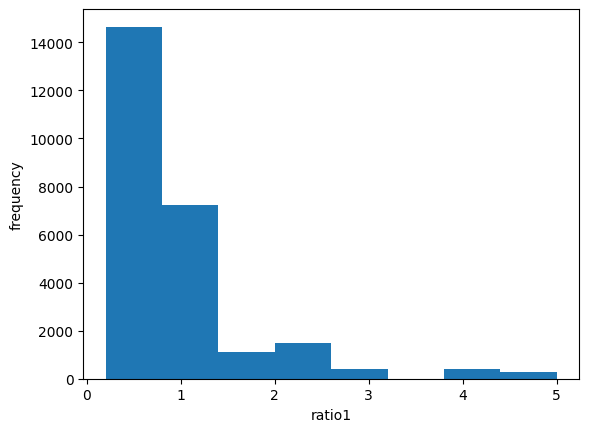

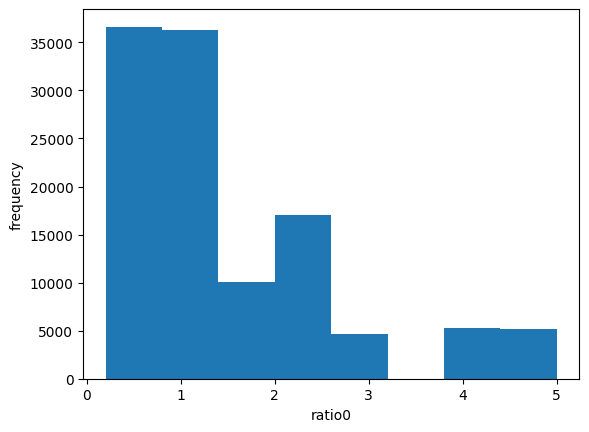

In [5]:
import matplotlib.pyplot as pyplot

honkshoo = {
    '40-45 hours': 6,
    'More than 8 hours': 9,
    '1-3 hours': 2,
    '9-11 hours': 10,
    '9-6 hours': 7,
    '8 hours': 8,
    '35-36 hours': 5,
    '1-2 hours': 1,
    '10-6 hours': 8,
    'than 5 hours': 5,
    '1-6 hours': 4,
    '8-9 hours': 9,
    '9-5': 7,
    '9-10 hours': 9,
    '20-21 hours': 3,
    '5-6 hours': 6,
    '45-48 hours': 7,
    '2-3 hours': 3,
    '6-7 hours': 6,
    '55-66 hours': 9,
    '45': 6,
    '7-8 hours': 7,
    '10-11 hours': 10,
    '4-6 hours': 5,
    'Less than 5 hours': 3,
    '4-5 hours': 4,
    '1-2 hours': 1,
    '6-8 hours': 7,
    '8-89 hours': 12,
    '49 hours': 7,
    '3-6 hours': 4,
    '60-65 hours': 9,
    '6 hours': 6,
    '9-5 hours': 7,
    '50-75 hours': 9,
    '3-4 hours': 3
}
# column values not in honkshoo: Moderate, Unhealthy, Have_you_ever_had_suicidal_thoughts, Work_Study_Hours, No, Meerut, 0, Vivan, Indore, Sleep_Duration, Pune

train_data['Sleep Duration'] = train_data['Sleep Duration'].map(honkshoo)
both_datasets['Sleep Duration'] = both_datasets['Sleep Duration'].map(honkshoo)

# replacing NaN values in 'Sleep Duration' with the mean
meansleep = train_data['Sleep Duration'].mean()
both_datasets['Sleep Duration'] = both_datasets['Sleep Duration'].fillna(meansleep)

# moving on to 'Dietary Habits' column
dhabits = {
    'Unhealthy': 1,
    'Moderate': 2,
    'Healthy': 3,
    'No Healthy': 1,
    'More Healthy': 3,
    'Less than Healthy': 1,
    'Less Healthy': 1
}
both_datasets['Dietary Habits'] = both_datasets['Dietary Habits'].map(dhabits)
both_datasets['Dietary Habits'] = both_datasets['Dietary Habits'].fillna(2)

# gonna experiment and drop certain columns to see if they would improve accuracy
both_datasets = both_datasets.drop(['City'], axis=1)
# getting dummies in both_datasets so that both train_data and test_data will have the same columns after splitting
both_datasets = pd.get_dummies(both_datasets)

#Version 22, feature engineering 'satisfaction_per_financialstress' Edit: realised this variable has a positive coefficient meaning as this value goes up, the greater the model thinks one has depression, which should not be the case so ill '#' the following line of code.
both_datasets['satisfaction_per_financialstress'] = both_datasets['Career Satisfaction']/both_datasets['Financial Stress']

#Version 23, feature engineering 'CareerHours_to_Sleep' Edit: thinking of removing this as it has a negative correlation, which makes no sense as a high work hour to sleep hour ratio should be bad for a person. oh wait but maybe a certain range is good but a ratio thats too high or too low is bad. THIS COLUMN CAN BE THE START OF QUANTIFYING WORK-LIFE BALANCE omg eureka moment. print out the row and print a distribution, print the depression or not row as well to see whats the sweet spot for the ratio, see the max few rat
both_datasets['CareerHours_to_Sleep'] = both_datasets['Work/Study Hours']/both_datasets['Sleep Duration']

# splitting both_datasets to get back train_data and test_data
train_data = both_datasets.iloc[:len(train_data)].copy()
test_data = both_datasets.iloc[len(train_data):].copy()

# Version 23: seeing the distribution of the 'CareerHours_to_Sleep' values in the train_data for both rows with and without depression
# this is to try and see what kind of ratios are most common in people with depression and without
train_depressed = train_data[train_data['Depression'] == 1] # with depression
print(len(train_depressed))
ratio1 = train_depressed['satisfaction_per_financialstress']
ratio1 = np.array(ratio1)
pyplot.hist(ratio1, bins=8) 
pyplot.xlabel('ratio1')
pyplot.ylabel('frequency')
pyplot.show()

train_notdepressed = train_data[train_data['Depression'] == 0]
ratio0 = train_notdepressed['satisfaction_per_financialstress']
ratio0 = np.array(ratio0)
pyplot.hist(ratio0, bins=8) 
pyplot.xlabel('ratio0')
pyplot.ylabel('frequency')
pyplot.show()

# # converting 'satisfaction_per_financialstress' into columns 'financiallyjustified' and 'financiallynotjustified'. Edit: putting this on hold for now
# train_data['financiallyjustified'] = train_data['satisfaction_per_financialstress'] >= 1
# train_data['financiallynotjustified'] = train_data['satisfaction_per_financialstress'] < 1
# test_data['financiallyjustified'] = test_data['satisfaction_per_financialstress'] >= 1
# test_data['financiallynotjustified'] = test_data['satisfaction_per_financialstress'] < 1

# it is with sadness that i announce the removal of my homie, column 'CareerHours_to_Sleep', from the dataset. And satisfaction_per_financialstress too, i dont need u no more
train_data = train_data.drop(['CareerHours_to_Sleep','satisfaction_per_financialstress'], axis=1)
test_data = test_data.drop(['CareerHours_to_Sleep', 'satisfaction_per_financialstress'], axis=1)

# Version 31 dealing with feature correlation
correlation_matrix = train_data.corr()
# print(correlation_matrix)
train_data = train_data.drop(['Have you ever had suicidal thoughts ?_No','Family History of Mental Illness_No'], axis=1)
test_data = test_data.drop(['Have you ever had suicidal thoughts ?_No', 'Family History of Mental Illness_No'], axis=1)

# 2) Configuring Machine Learning model (finally)

100
Threshold: 0.25, TPR: 0.9024003173973418, FPR: 0.07030607385601108, Accuracy: 0.92480
Threshold: 0.45, TPR: 0.8369371156516564, FPR: 0.03913589332871553, Accuracy: 0.93866
Threshold: 0.5, TPR: 0.8161079150962111, FPR: 0.03376769557123685, Accuracy: 0.93933
Threshold: 0.55, TPR: 0.7901210077365602, FPR: 0.029481795748733712, Accuracy: 0.93820
Threshold: 0.6, TPR: 0.7651259670700258, FPR: 0.02510931209143253, Accuracy: 0.93731
Threshold: 0.7, TPR: 0.6970839119222376, FPR: 0.0172301831248106, Accuracy: 0.93159


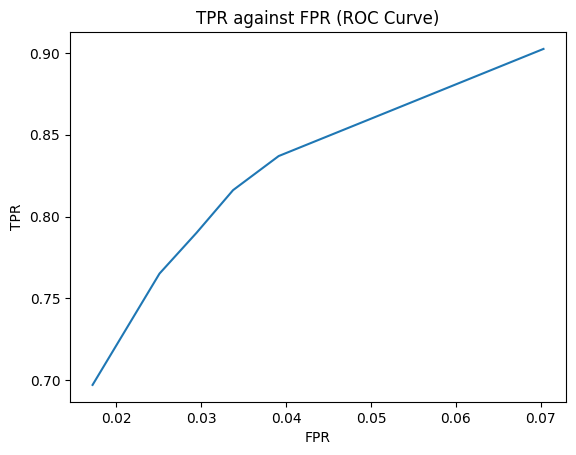

In [6]:
# getting X and y from the train_data
X = train_data.drop('Depression', axis=1)
columnnames = X.columns
print(len(columnnames))
y = train_data['Depression']

# scaling the numerical values in X
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# splitting up the training data further to get a mock test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# to start, lets try a simple Logistic Regression classification model with just 1 custom hyperparam
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0, max_iter=150, penalty='l2', C=0.1) # Version 25: introducing l2 regularization
model.fit(X_train, y_train)
# predictions = model.predict(X_test)

# looping thru different threshold values to get coords for roc curve
from sklearn.metrics import accuracy_score, confusion_matrix
TPRvalues = []
FPRvalues = []
for threshold in [0.25, 0.45, 0.5, 0.55, 0.6, 0.7]:
    y_probs = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    predictions = (y_probs >= threshold).astype(int)
    cm = confusion_matrix(y_test, predictions)
    # Extract TP, FP, TN, FN from the confusion matrix
    TP = cm[1, 1]  # True Positives
    TN = cm[0, 0]  # True Negatives
    FP = cm[0, 1]  # False Positives
    FN = cm[1, 0]  # False Negatives
    
    # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)

    TPRvalues.append(TPR)
    FPRvalues.append(FPR)
    accuracy = accuracy_score(y_test, predictions)
    print(f'Threshold: {threshold}, TPR: {TPR}, FPR: {FPR}, Accuracy: {str(accuracy)[:7]}')

# plotting ROC curve now
import matplotlib.pyplot as plt
plt.plot(FPRvalues, TPRvalues)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('TPR against FPR (ROC Curve)')
plt.show()
    
# # the portion below about coefficients are not relevant to randomforestclassifiers
# # seeing which features were most influential during model training by looking at variables coefficients
# coefficients = model.coef_
# coefficients = coefficients.flatten()
# feat_impt = pd.DataFrame(abs(coefficients), index=columnnames, columns=["abs coefficient"])
# feat_impt = feat_impt.sort_values(by='abs coefficient', ascending=False)
# print(feat_impt.head(60))

# Submission

In [7]:
model.fit(X, y)
test_data = test_data.drop('Depression', axis=1)
print(len(test_data.columns))
test_data = scaler.fit_transform(test_data)
pred = model.predict(test_data)

# creating submission Dataframe
output = pd.DataFrame({'id': Id_Series, 'Depression': pred})
print(output)
output.to_csv('submission.csv', index=False)
print('success yahuu')

100
           id  Depression
0      140700         0.0
1      140701         0.0
2      140702         0.0
3      140703         1.0
4      140704         0.0
...       ...         ...
93795  234495         0.0
93796  234496         1.0
93797  234497         0.0
93798  234498         1.0
93799  234499         0.0

[93800 rows x 2 columns]
success yahuu
